# Bayesian Analysis of Math Exam Scores

## Problem Statement

You are provided with a dataset of math exam scores from Estonian primary schools. Your task is to build a Bayesian model to better understand the factors that influence exam performance.

## Data Description

The dataset includes the following variables:
- `year`: The year of the exam (2016-2023), with [2020 missing due to the COVID-19 pandemic](https://www.ohtuleht.ee/998159/pohikooli-eksamid-jaavad-ara-riigieksamid-toimuvad)
- `county`: The county where the student took the exam
- `domestic_background`: Whether the student is Estonian or Russian
- `gender`: Student's gender (Male/Female)
- `avg_grade`: The student's average grade (from 1 to 5, continuous)
- `exam_score`: The exam score (0-50 points)


In [195]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('math_exam_scores.csv', sep=";").sample(2000) # Work with a smaller dataset at first so that you don't have to wait 10 minutes every time you sample the model.
#df = pd.read_csv('math_exam_scores.csv', sep=";") 

# DATA MANIPULATIONS #
## YEAR ##
# Convert year to category as there are probably non-linear effects at play
df['year'] = df['year'].astype('category')

# Encode categorical variable 'year' as integers for indexing
df['year'] = df['year'].cat.codes
n_years = df['year'].nunique()

## COUNTY ##
# Make sure county is a category
df['county'] = df['county'].astype('category')

# Encode categorical variable 'county'
df['county'] = df['county'].cat.codes
n_counties = df['county'].nunique()

## GENDER ##
# Convert domestic_background to numerical binary
remap = {'Male': 0, 'Female': 1}
pd.set_option("future.no_silent_downcasting", True)
df['gender'] = df['gender'].replace(remap).values.astype(int)

## DOMESTIC BACKGROUND ##
# Convert domestic_background to numerical binary
remap = {'Estonian': 0, 'Russian': 1}
df['domestic_background'] = df['domestic_background'].replace(remap).values.astype(int)

## CONTINIOUS VARIABLES ##
# Rescaling exam score and since the Beta distribution is the most intuitive choice, then make sure that
#  the rescled exam score is strictly within open interval (0,1), ie. cannot be [0,1].
eps = 1e-6
df['exam_score_rescaled'] = (df['exam_score'] / 50.0).clip(eps, 1-eps)

# Rescaling avg_grade
df['avg_grade_rescaled'] = (
    (df['avg_grade'] - df['avg_grade'].min()) /
    (df['avg_grade'].max() - df['avg_grade'].min())
)

models = {}

In [118]:
df.describe()

,year,county,domestic_background,gender,exam_score,avg_grade,exam_score_rescaled,avg_grade_rescaled
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,3.207000,3.867500,0.209500,0.486500,37.006500,3.732576,0.740130,0.724446
std,2.015237,4.713815,0.407054,0.499943,10.571061,0.974805,0.211421,0.211966
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.400945,0.000000,0.000000
25%,1.750000,0.000000,0.000000,0.000000,31.000000,3.122986,0.620000,0.591894
50%,3.000000,2.000000,0.000000,0.000000,40.000000,3.949986,0.800000,0.771721
75%,5.000000,8.000000,0.000000,1.000000,45.250000,4.523467,0.905000,0.896421
max,6.000000,14.000000,1.000000,1.000000,50.000000,4.999812,1.000000,1.000000


# Initial analysis

The DAG that we'll take as the basis of our analysis.

<img src="DAG.png" alt="drawing" width="400"/>

## Justification for the DAG

**Year** -- Since this standardised matematics exam is administered to the whole country simultaneously in set year, then all of the possible influencing factors are captured in this factor. Exam exercises are changed every year, so [some years tend to be easier](https://www.err.ee/1609007237/pohikooli-matemaatikaeksami-sooritused-olid-paremad-kui-kahel-eelneval-aastal) and some harder, there are global effects that come into play (eg. COVID-19 pandemic), policy changes, cohort effects etc.<br>
Since all other variables result from a progression of longer processes (eg. county effects on exam score) and any shift in them cannot be attributed to a single year, then **Year** of the exam does not have influence on other factors.

**County** -- Differences in school education quality, population parameters (eg. urban/rural porportions), socio/economic factors are encompassed into the county variable. For that reason county is set to influence academic ability and average grade. <br>
The distribution of Estonian and Russian speaking families is different between counties. Therefore count -> domestic_background. 

**Domestic background** -- [PISA statistics](https://harno.ee/sites/default/files/documents/2023-12/Pisa_tulemused_2022_veebi.pdf) show that Estonian and Russian students' academic ability differs quite a lot in Estonia.

**Gender** -- [PISA statistics](https://harno.ee/sites/default/files/documents/2023-12/Pisa_tulemused_2022_veebi.pdf) show that there is a gap in academic ability between boys and girls in Estonia.

**Academic ability** -- Exam score is meant to measure academic ability of a student, but its an approximation. Thus its taken as a latent variable into the model. Academic ability is influenced by multiple factors such as school education quality, environment (mediated by county), domestic background and gender etc. <br> 
Average grade also tries to measure academic ability, but has other influencing factors at play (eg. group level effects of school and county, girls tend to worry more about grades than boys). So it cannot be taken as the same kind of measure of academic ability as the exam score.



# Let's model

## Model nr 1
First a simple model with just year in the mix. The 

In [197]:
# Let's model

# First a simple model with just year in the mix
with pm.Model() as model_m1:
    # Priors
    intercept = pm.Normal("intercept", mu=1, sigma=1)
    beta_year = pm.Normal("beta_year", mu=1, sigma=1, shape=n_years)

    alpha = intercept + beta_year[df.year]
    #alpha = pm.math.sigmoid(ac_ability + beta_grade * df.avg_grade_scaled)
    
    # Likelihood
    y_obs = pm.Beta("y_obs", alpha=alpha, beta=1, observed=df.exam_score_rescaled)
    #y_obs = pm.Normal("y_obs", mu=alpha, sigma=1, observed=df.exam_score)

    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

# Summary
az.summary(trace, round_to=2) 

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.14        23           221.35 draws/s   0:00:09   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.21        7            228.17 draws/s   0:00:08   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.21        15           226.64 draws/s   0:00:08   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.16        15           157.07 draws/s   0:00:12   0:00:00

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.86,0.35,1.16,2.46,0.01,0.01,603.75,742.53,1.01
beta_year[0],0.54,0.38,-0.14,1.25,0.01,0.01,704.82,1003.97,1.01
beta_year[1],0.15,0.37,-0.52,0.81,0.01,0.01,652.75,854.28,1.01
beta_year[2],1.30,0.39,0.57,2.03,0.01,0.01,714.29,940.60,1.01
beta_year[3],0.20,0.37,-0.48,0.89,0.01,0.01,655.48,877.24,1.01
beta_year[4],2.79,0.42,2.03,3.59,0.01,0.01,840.76,1034.13,1.00
beta_year[5],2.11,0.40,1.35,2.86,0.01,0.01,763.94,1105.82,1.01
beta_year[6],0.66,0.37,-0.02,1.35,0.01,0.01,682.13,955.33,1.01


In [199]:
with model_m1:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)

pm.loo(trace)

Computing ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

Computed from 4000 posterior samples and 2000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   820.26    34.15
p_loo        8.17        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     2000  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [201]:
models['model_m1'] = trace

               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept     1.863  0.351   1.160    2.462      0.014    0.011     604.0   
beta_year[0]  0.542  0.376  -0.138    1.248      0.014    0.010     705.0   
beta_year[1]  0.145  0.366  -0.525    0.809      0.014    0.010     653.0   
beta_year[2]  1.303  0.387   0.573    2.032      0.014    0.010     714.0   
beta_year[3]  0.201  0.369  -0.483    0.886      0.014    0.010     655.0   
beta_year[4]  2.787  0.416   2.025    3.585      0.014    0.010     841.0   
beta_year[5]  2.106  0.400   1.346    2.860      0.014    0.010     764.0   
beta_year[6]  0.657  0.369  -0.021    1.351      0.014    0.010     682.0   

              ess_tail  r_hat  
intercept        743.0   1.01  
beta_year[0]    1004.0   1.01  
beta_year[1]     854.0   1.01  
beta_year[2]     941.0   1.01  
beta_year[3]     877.0   1.01  
beta_year[4]    1034.0   1.00  
beta_year[5]    1106.0   1.01  
beta_year[6]     955.0   1.01  


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'beta_year'}>,
        <Axes: title={'center': 'beta_year'}>]], dtype=object)

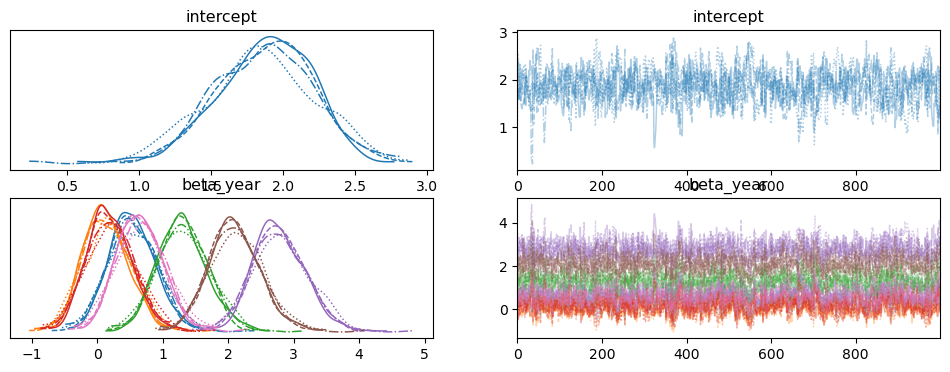

In [203]:
# Model diagnostics
print(pm.summary(trace))
pm.plot_trace(trace)

array([[<Axes: title={'center': 'intercept'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'beta_year\n0'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'beta_year\n1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'beta_year\n2'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'beta_year\n3'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'beta_year\n4'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'beta_year\n5'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'beta_year\n6'}, xlabel='Total number of draws', ylabel='ESS'>]],
      dtype=object)

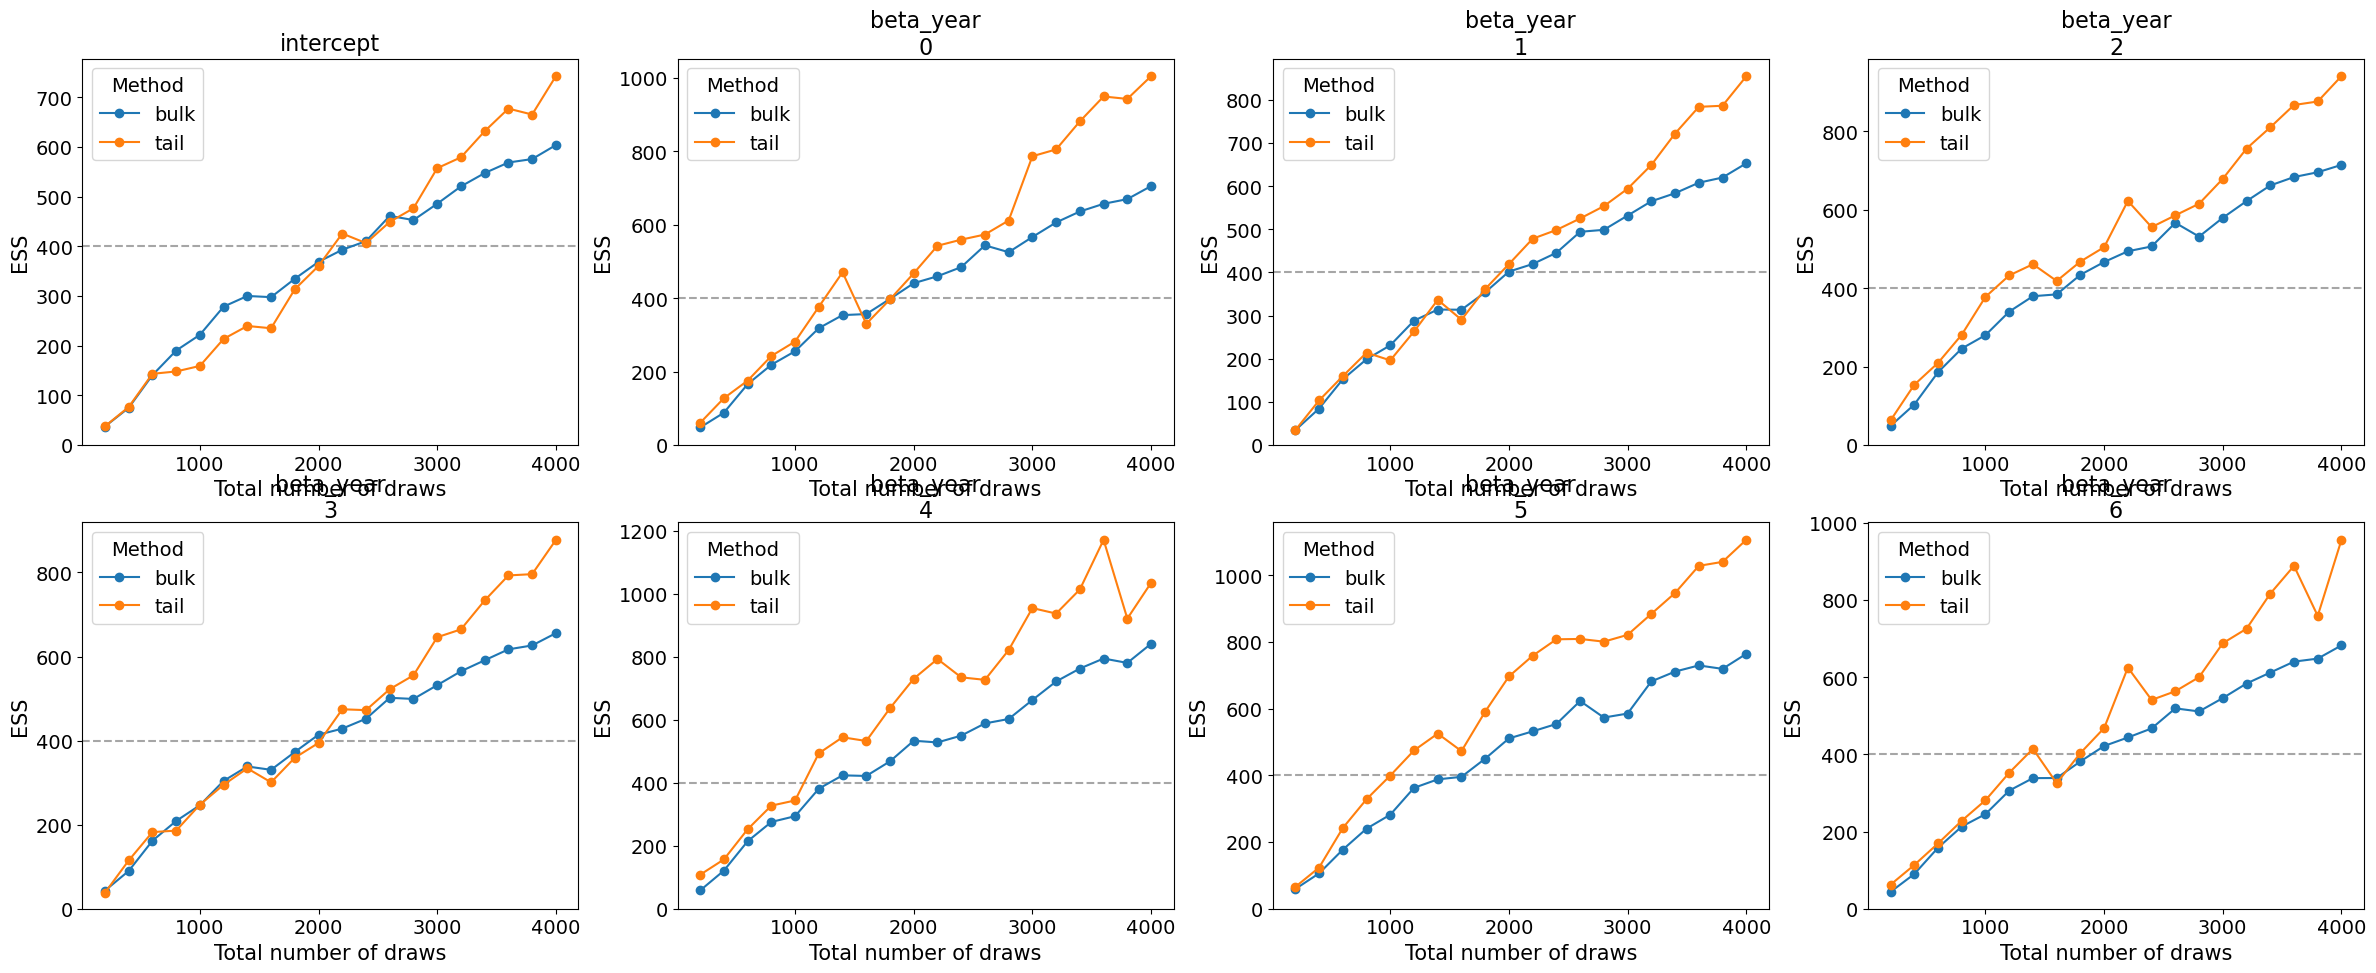

In [205]:
pm.plot_ess(trace, kind="evolution")

<Axes: xlabel='y_obs'>

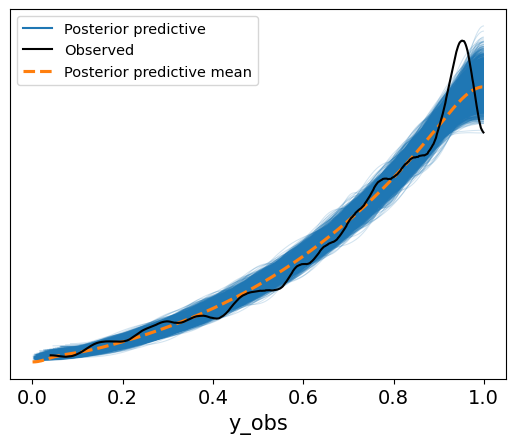

In [207]:
pm.plot_ppc(trace)

array([[<Axes: title={'center': 'beta_year\n0'}>,
        <Axes: title={'center': 'beta_year\n1'}>,
        <Axes: title={'center': 'beta_year\n2'}>],
       [<Axes: title={'center': 'beta_year\n3'}>,
        <Axes: title={'center': 'beta_year\n4'}>,
        <Axes: title={'center': 'beta_year\n5'}>],
       [<Axes: title={'center': 'beta_year\n6'}>, <Axes: >, <Axes: >]],
      dtype=object)

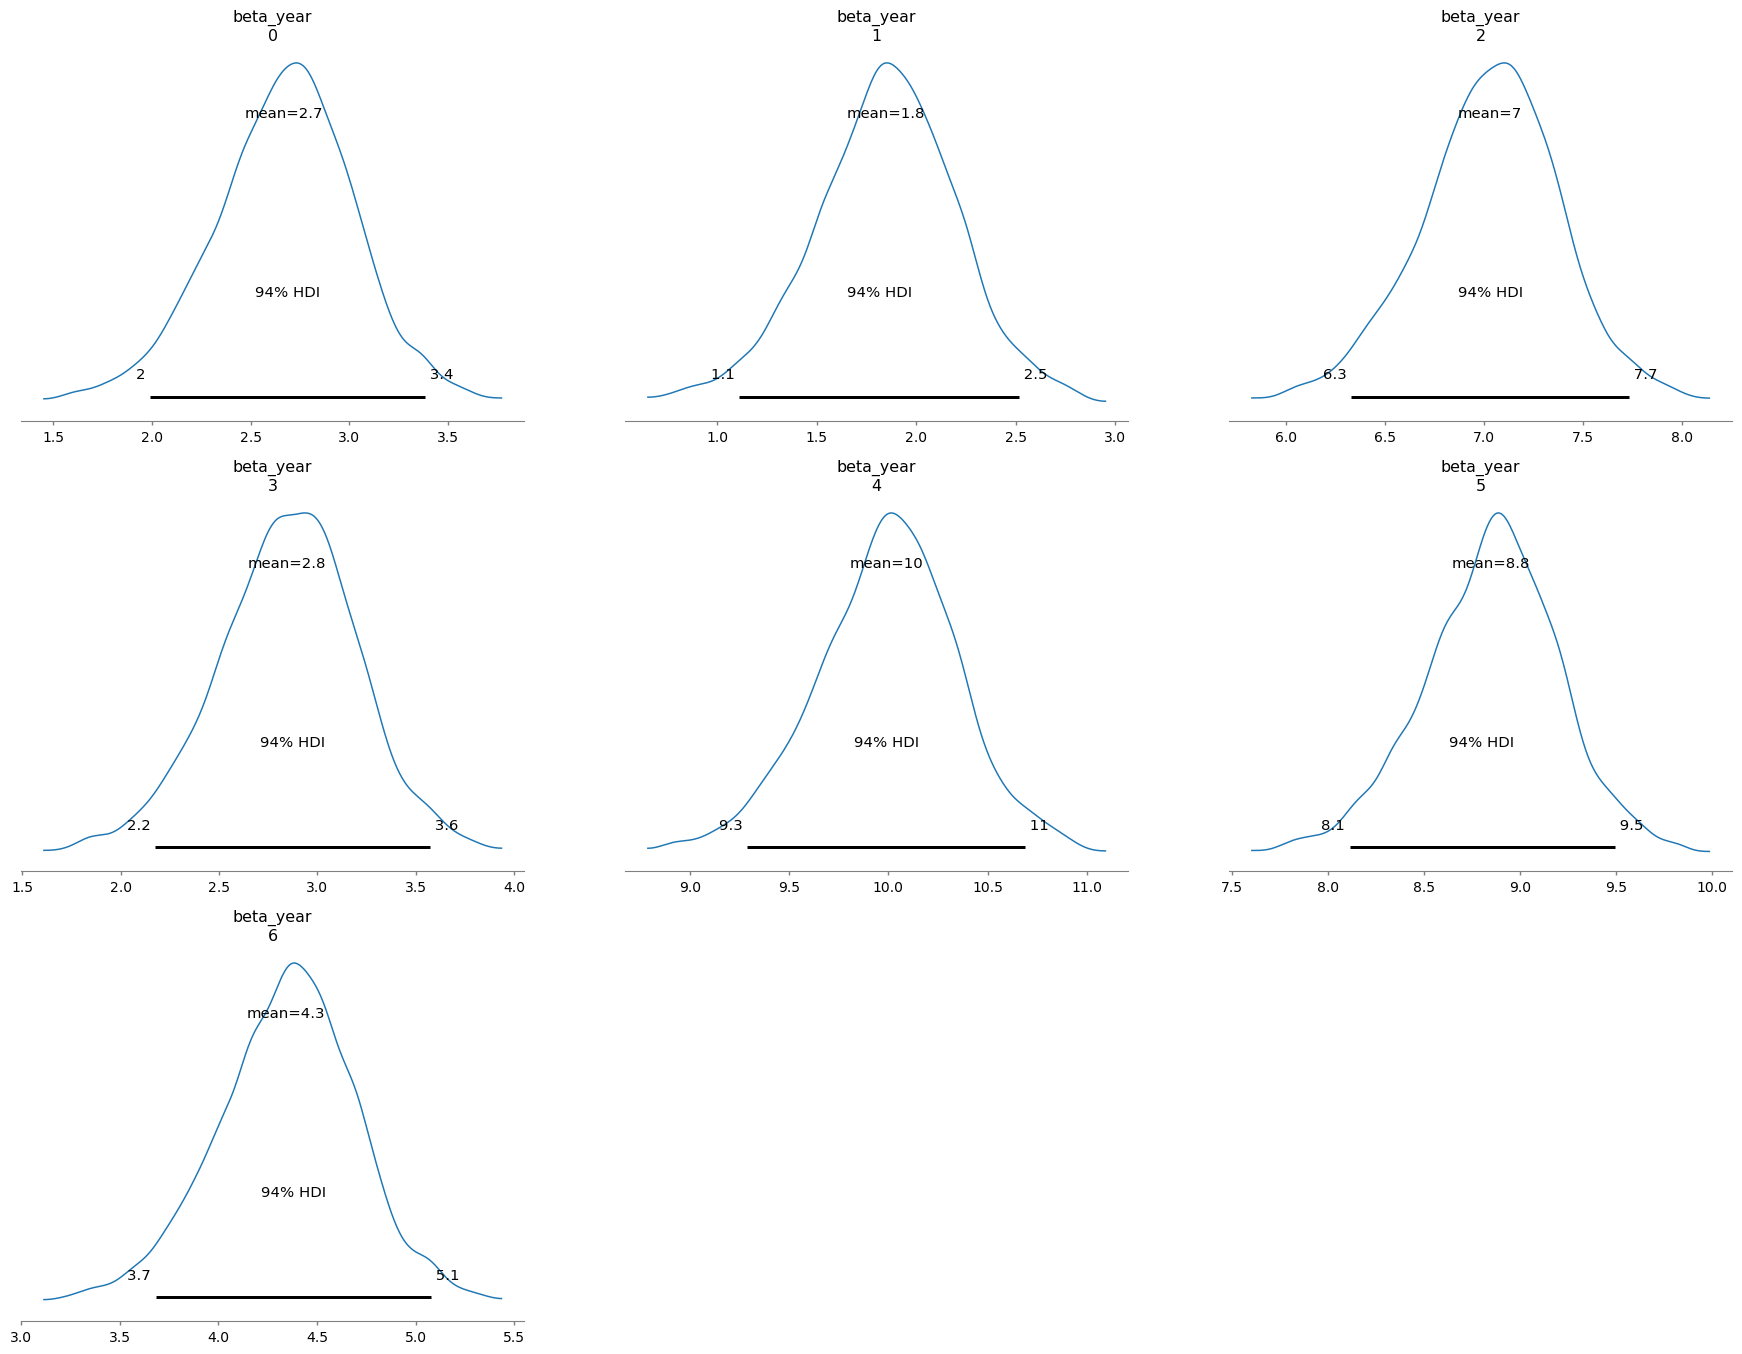

In [163]:
pm.plot_posterior(trace, var_names=["beta_year"], textsize=10)

In [175]:
# Model with everything in
with pm.Model() as model_m2:
    # Priors
    intercept = pm.Normal("intercept", mu=1, sigma=1)
    beta_gender = pm.Normal("beta_gender", mu=0, sigma=1)
    beta_domestic = pm.Normal("beta_domestic", mu=0, sigma=1)
    county_mu = pm.Normal("county_mu", mu=0, sigma=1, shape=n_counties)
    beta_year = pm.Normal("beta_year", mu=1, sigma=1, shape=n_years)

    # Latent academic ability (one per individual)
    mu_ability = (
        intercept
        + county_mu[df.county]  # county effect
        + beta_gender * df.gender
        + beta_domestic * df.domestic_background
    )

    # Latent variable: academic ability
    academic_ability = pm.Normal("academic_ability", mu=mu_ability, sigma=1, shape=df.shape[0])
    
    alpha = academic_ability * pm.math.sigmoid(intercept + beta_year[df.year.values])*10
    #alpha = pm.math.sigmoid(ac_ability + beta_grade * df.avg_grade_scaled)
    #unt = pm.Deterministic('untreated', alpha)
    
    # Likelihood
    y_obs = pm.Normal("y_obs", mu=academic_ability, sigma=1, observed=df["exam_score_rescaled"].values)

    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

# Summary
az.summary(trace, round_to=2) 

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.09        31           137.64 draws/s   0:00:14   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.11        63           97.32 draws/s    0:00:20   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.10        63           96.14 draws/s    0:00:20   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.08        63           81.22 draws/s    0:00:24   0:00:00

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.72,0.26,0.23,1.21,0.01,0.01,624.48,1131.39,1.0
beta_gender,0.01,0.06,-0.11,0.12,0.00,0.00,2877.80,2888.69,1.0
beta_domestic,0.02,0.09,-0.15,0.17,0.00,0.00,3906.17,3166.73,1.0
county_mu[0],0.01,0.26,-0.49,0.49,0.01,0.01,639.79,1221.54,1.0
county_mu[1],-0.07,0.46,-0.92,0.79,0.01,0.01,1655.81,2049.97,1.0
...,...,...,...,...,...,...,...,...,...
academic_ability[1995],0.62,0.69,-0.58,1.99,0.01,0.01,7490.21,2929.68,1.0
academic_ability[1996],0.49,0.71,-0.81,1.79,0.01,0.01,7722.44,2920.11,1.0
academic_ability[1997],0.71,0.72,-0.58,2.06,0.01,0.01,8112.50,2823.32,1.0
academic_ability[1998],0.84,0.72,-0.52,2.20,0.01,0.01,6601.02,2895.93,1.0


                         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
intercept               0.743  0.255   0.277    1.216      0.011    0.005   
beta_gender            -0.018  0.063  -0.133    0.105      0.001    0.001   
beta_domestic           0.032  0.088  -0.133    0.191      0.002    0.001   
county_mu[0]            0.003  0.258  -0.478    0.481      0.011    0.005   
county_mu[1]            0.072  0.418  -0.715    0.845      0.011    0.006   
...                       ...    ...     ...      ...        ...      ...   
academic_ability[1995]  0.674  0.708  -0.632    2.065      0.008    0.013   
academic_ability[1996]  0.832  0.698  -0.418    2.215      0.007    0.014   
academic_ability[1997]  0.776  0.701  -0.548    2.085      0.007    0.012   
academic_ability[1998]  0.839  0.735  -0.606    2.162      0.009    0.014   
academic_ability[1999]  0.669  0.729  -0.754    1.996      0.008    0.014   

                        ess_bulk  ess_tail  r_hat  
intercept              

KeyboardInterrupt: 

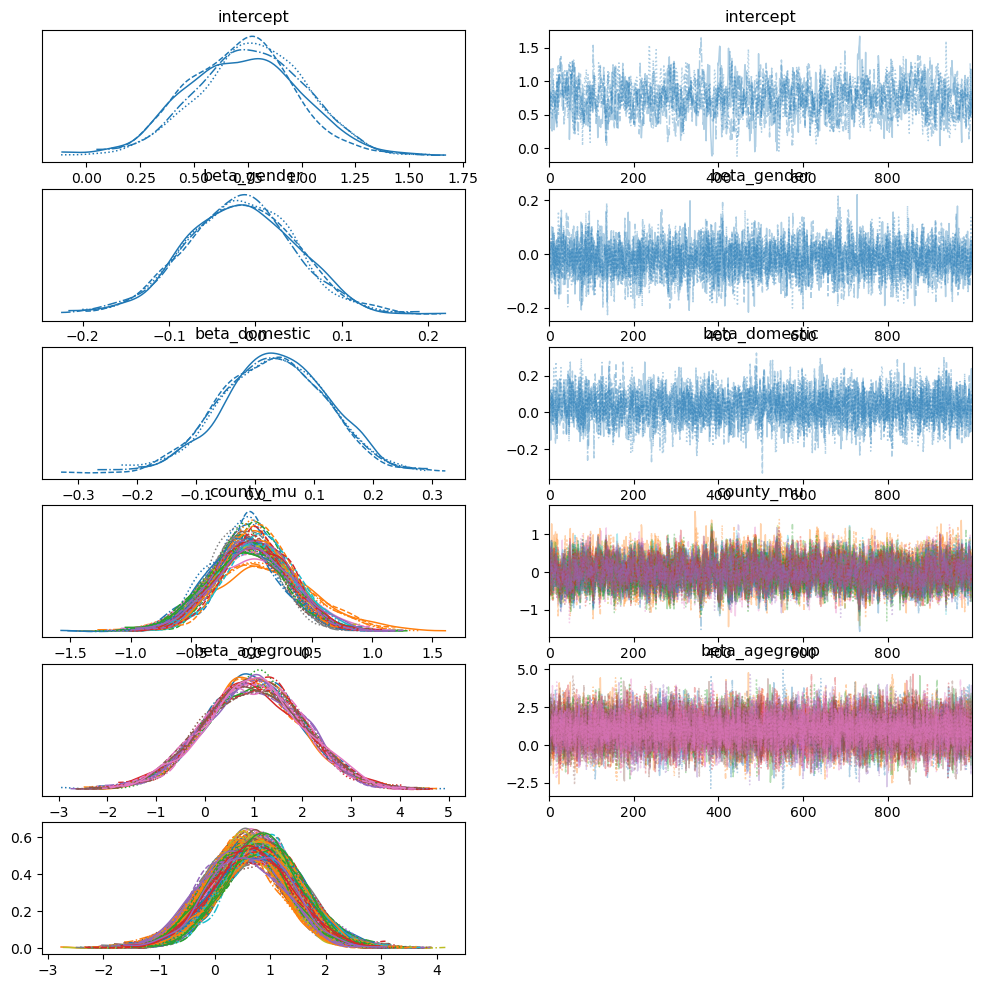

In [124]:
# Model diagnostics
print(pm.summary(trace))
pm.plot_trace(trace)

## Model comparison

In [ ]:
comp = az.compare(t_dict, var_name='obs')
print(comp)
az.plot_compare(comp)